In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam

# General Notes

Bin values should be from -6.5 to 6.5 instead of starting at -5.5

Inputs are everything in summary file + Precursor, Gas, and Aerosol
StandardScaler



# Summary file

The summary file contains the metadata for each experiment. Load first in order to know which experiment files to load later.

In [2]:
summary_file = "/glade/work/dgagne/Batch1_toluene/GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv"
summary_data = pd.read_csv(summary_file, skiprows=3)
summary_data.columns = summary_data.columns.str.strip()
summary_data.columns
summary_data["idnum"] = summary_data.index

In [3]:
summary_data

,id,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),idnum
0,Exp0,270.0,0.0,0.01,1.0,0.01,1.0,0
1,Exp1,270.0,0.0,0.01,1.0,0.01,5.0,1
2,Exp2,270.0,0.0,0.01,1.0,0.01,10.0,2
3,Exp3,270.0,0.0,0.01,1.0,0.10,1.0,3
4,Exp4,270.0,0.0,0.01,1.0,0.10,5.0,4
...,...,...,...,...,...,...,...,...
5395,Exp5395,300.0,90.0,100.00,150.0,3.00,5.0,5395
5396,Exp5396,300.0,90.0,100.00,150.0,3.00,10.0,5396
5397,Exp5397,300.0,90.0,100.00,150.0,10.00,1.0,5397
5398,Exp5398,300.0,90.0,100.00,150.0,10.00,5.0,5398


In [4]:
def load_data(path, summary_file, species="toluene_kOH"):
    """
    Load a set of experiment files based on a summary file.
    
    Args:
        path: Path to the directory containing summary and experiment files
        summary_file: Name of the summary file (should not contain the path)
        species: Name of the precursor chemical species
    
    Returns:
        exp_data_merged: All time series data for every experiment in pandas DataFrame
        summary_data: Summary experiment data file in pandas DataFrame
    """
    summary_data = pd.read_csv(join(path, summary_file), skiprows=3)
    summary_data.columns = summary_data.columns.str.strip()
    summary_data["idnum"] = summary_data.index
    exp_data_list = []
    for i, id_val in enumerate(summary_data["id"]):
        if i % 100 == 0:
            print(id_val)
        exp_file = join(path, f"ML2019_{species}_ML2019_{id_val}.csv")
        exp_data_list.append(pd.read_csv(exp_file))
        exp_data_list[-1]["id"] = id_val
        exp_data_list[-1]["idnum"] = i
    exp_data_combined = pd.concat(exp_data_list, ignore_index=True)
    exp_data_combined.columns = exp_data_combined.columns.str.strip()
    exp_data_merged = pd.merge(exp_data_combined, summary_data, left_on="idnum", right_on="idnum")
    return exp_data_merged, summary_data
    

In [10]:
ls /glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/ML2019_toluene_kOH_ML2019_Exp1900.csv

/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/ML2019_toluene_kOH_ML2019_Exp1900.csv


Run the cell below to load all experiment data. It will take a few minutes to run.

In [5]:
exp_data_merged, summary_data = load_data("/glade/work/dgagne/Batch1_toluene", 
                                          "GAR0084_Exp_List_TEXT_PreCompile_BatchSubmit_v0.csv")

Exp0
Exp100
Exp200
Exp300
Exp400
Exp500
Exp600
Exp700
Exp800
Exp900
Exp1000
Exp1100
Exp1200
Exp1300
Exp1400
Exp1500
Exp1600
Exp1700
Exp1800
Exp1900
Exp2000
Exp2100
Exp2200
Exp2300
Exp2400
Exp2500
Exp2600
Exp2700
Exp2800
Exp2900
Exp3000
Exp3100
Exp3200
Exp3300
Exp3400
Exp3500
Exp3600
Exp3700
Exp3800
Exp3900
Exp4000
Exp4100
Exp4200
Exp4300
Exp4400
Exp4500
Exp4600
Exp4700
Exp4800
Exp4900
Exp5000
Exp5100
Exp5200
Exp5300


Here is a summary of what the data look like for a single experiment.

In [14]:
exp_data_merged.loc[exp_data_merged["idnum"] == 10]

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -5.5,Gas [ug/m3] Bin02: lg(C*) = -4.5,Gas [ug/m3] Bin03: lg(C*) = -3.5,Gas [ug/m3] Bin04: lg(C*) = -2.5,Gas [ug/m3] Bin05: lg(C*) = -1.5,Gas [ug/m3] Bin06: lg(C*) = -0.5,Gas [ug/m3] Bin07: lg(C*) = 0.5,Gas [ug/m3] Bin08: lg(C*) = 1.5,...,N/C Bin14: lg(C*) = -6.5,id_x,idnum,id_y,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
5760,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5761,301.519989,0.037332,1.113952e-21,4.070264e-20,6.686731e-17,1.389201e-16,4.066288e-15,1.757855e-13,9.118843e-12,5.212791e-12,...,0.001404,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5762,602.039978,0.036979,8.465895e-21,2.655437e-19,1.143732e-16,1.790802e-15,2.412341e-14,4.494002e-12,6.651374e-11,3.789099e-11,...,0.001658,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5763,902.559998,0.036628,3.248028e-20,7.934065e-19,2.488888e-15,9.371479e-15,1.919735e-13,2.865727e-11,2.018920e-10,1.266861e-10,...,0.001925,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
5764,1203.079956,0.036281,1.030769e-19,2.069284e-18,3.476972e-15,2.874213e-14,4.096286e-13,1.022437e-10,4.320647e-10,2.948841e-10,...,0.002200,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,171597.921875,0.000165,1.043278e-13,1.525949e-12,1.460513e-10,1.237334e-09,3.408873e-08,1.015127e-06,4.097190e-07,9.564674e-09,...,0.170063,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6332,171898.437500,0.000163,1.041344e-13,1.523302e-12,1.458010e-10,1.234989e-09,3.408640e-08,1.008500e-06,4.094157e-07,9.512465e-09,...,0.170112,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6333,172198.953125,0.000162,1.039410e-13,1.520657e-12,1.455456e-10,1.232646e-09,3.408390e-08,1.001909e-06,4.091112e-07,9.417578e-09,...,0.170160,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0
6334,172499.484375,0.000160,1.037479e-13,1.518013e-12,1.452935e-10,1.230307e-09,3.408143e-08,9.953547e-07,4.088050e-07,9.325147e-09,...,0.170209,Exp10,10,Exp10,270.0,0.0,0.01,1.0,1.0,5.0


Here are the relevant input and output columns for training the neural network. We are going to start with a subset of the data and then add more variables over time if we get good performance with these.

In [15]:
input_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
    'temperature (K)',
    'solar zenith angle (degree)',
    'pre-existing aerosols (ug/m3)',
    'o3 (ppb)',
    'nox (ppb)',
    'oh (10^6 molec/cm3)',
    "idnum"]

output_exp_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -5.5',
    'Gas [ug/m3] Bin02: lg(C*) = -4.5',
    'Gas [ug/m3] Bin03: lg(C*) = -3.5',
    'Gas [ug/m3] Bin04: lg(C*) = -2.5',
    'Gas [ug/m3] Bin05: lg(C*) = -1.5',
    'Gas [ug/m3] Bin06: lg(C*) = -0.5',
    'Gas [ug/m3] Bin07: lg(C*) =  0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  1.5',
    'Gas [ug/m3] Bin09: lg(C*) =  2.5',
    'Gas [ug/m3] Bin10: lg(C*) =  3.5',
    'Gas [ug/m3] Bin11: lg(C*) =  4.5',
    'Gas [ug/m3] Bin12: lg(C*) =  5.5',
    'Gas [ug/m3] Bin13: lg(C*) =  6.5',
    'Gas [ug/m3] Bin14: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin14: lg(C*) = -6.5',
    "idnum"]

We will now create separate input and output dataframes that are offset by 1 time step and have only the input and output variables listed above.

In [16]:
input_data_list = []
output_data_list = []
for exp in np.unique(exp_data_merged.idnum):
    if exp % 100 == 0:
        print(exp)
    input_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, input_exp_cols].reset_index(drop=True).iloc[:-1])
    output_data_list.append(exp_data_merged.loc[exp_data_merged.idnum==exp, input_exp_cols].reset_index(drop=True).iloc[1:])
input_data = pd.concat(input_data_list, ignore_index=True)
output_data = pd.concat(output_data_list, ignore_index=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300


In [18]:
def dense_neural_net(num_layers, num_neurons, activation, learning_rate, input_train_norm, output_train_norm):
    input_layer = Input(input_train_norm.shape[1])
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(output_train_norm.shape[1])(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    return mod

In [41]:
output_data

,Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -5.5,Gas [ug/m3] Bin02: lg(C*) = -4.5,Gas [ug/m3] Bin03: lg(C*) = -3.5,Gas [ug/m3] Bin04: lg(C*) = -2.5,Gas [ug/m3] Bin05: lg(C*) = -1.5,Gas [ug/m3] Bin06: lg(C*) = -0.5,Gas [ug/m3] Bin07: lg(C*) = 0.5,Gas [ug/m3] Bin08: lg(C*) = 1.5,Gas [ug/m3] Bin09: lg(C*) = 2.5,...,Aerosol [ug_m3] Bin12: lg(C*) = 5.5,Aerosol [ug_m3] Bin13: lg(C*) = 6.5,Aerosol [ug_m3] Bin14: lg(C*) = -6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),idnum
0,0.037617,8.155637e-22,1.263573e-21,9.544929e-15,3.442271e-15,4.575265e-14,4.100273e-14,6.194109e-12,4.735757e-13,3.587263e-13,...,3.006734e-14,3.498849e-13,1.611725e-11,270.0,0.0,0.01,1.0,0.01,1.0,0
1,0.037546,3.133494e-20,2.270322e-20,8.156982e-14,3.495141e-14,1.502196e-13,9.871184e-14,1.530814e-10,1.336650e-11,6.554171e-12,...,6.695180e-13,1.730959e-12,1.901978e-11,270.0,0.0,0.01,1.0,0.01,1.0,0
2,0.037474,7.587363e-19,2.431687e-19,1.762050e-13,1.613213e-13,3.800421e-13,5.421686e-13,7.975155e-10,7.596344e-11,4.056534e-11,...,3.572964e-12,4.297890e-12,2.214155e-11,270.0,0.0,0.01,1.0,0.01,1.0,0
3,0.037403,6.855157e-18,1.987312e-18,4.766778e-13,6.004466e-13,9.435875e-13,1.677539e-12,2.326122e-09,2.405779e-10,1.320380e-10,...,1.104469e-11,8.062719e-12,2.534768e-11,270.0,0.0,0.01,1.0,0.01,1.0,0
4,0.037332,3.443392e-17,1.003384e-17,1.250521e-12,1.829096e-12,2.037699e-12,3.966482e-12,5.063882e-09,5.614299e-10,3.121042e-10,...,2.566590e-11,1.300682e-11,2.863879e-11,270.0,0.0,0.01,1.0,0.01,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104995,0.000003,1.311393e-20,2.077611e-19,1.280348e-15,1.538136e-12,2.586186e-11,5.037383e-10,9.675625e-10,3.249457e-09,1.233069e-05,...,1.290958e-05,1.407636e-06,3.499209e-07,300.0,90.0,100.00,150.0,10.00,10.0,5399
3104996,0.000003,1.285304e-20,2.040848e-19,1.236718e-15,1.505193e-12,2.485606e-11,4.948298e-10,9.546565e-10,3.200388e-09,1.216130e-05,...,1.301735e-05,1.417636e-06,3.505694e-07,300.0,90.0,100.00,150.0,10.00,10.0,5399
3104997,0.000002,1.261603e-20,2.007593e-19,1.209243e-15,1.472984e-12,2.447515e-11,4.860567e-10,9.388274e-10,3.151121e-09,1.199395e-05,...,1.312596e-05,1.427726e-06,3.512362e-07,300.0,90.0,100.00,150.0,10.00,10.0,5399
3104998,0.000002,1.236282e-20,1.971223e-19,1.181575e-15,1.441464e-12,2.411553e-11,4.774176e-10,9.244614e-10,3.102326e-09,1.182844e-05,...,1.323535e-05,1.437904e-06,3.519205e-07,300.0,90.0,100.00,150.0,10.00,10.0,5399


* Number of folds: 5
* `num_layers`: Vary from 1 to 5
* `num_neurons`: Vary from 20 to 200 in steps of 20
* `activation`: Try "relu", "tanh", "selu"
* `learning_rate`: 0.01 to 0.00001 dividing by 10 
* `epochs`: Try 10, 20, 50
* `batch_size`: 256, 512, 1024, 2048

Pick a subset of these options and manually retrain the neural network a few times.

In [19]:
num_folds = 3
exp_kfold = GroupKFold(num_folds)
neural_nets = []
num_layers = 2
num_neurons = 100
activation = "tanh"
learning_rate = 0.0001
epochs = 20
batch_size = 512
dnns = []
norm_rmse_folds = np.zeros((num_folds, len(output_exp_cols[:-1])))
norm_mae_folds = np.zeros((num_folds, len(output_exp_cols[:-1])))
norm_me_folds = np.zeros((num_folds, len(output_exp_cols[:-1])))
out_preds = np.zeros((output_data.shape[0], len(output_exp_cols)-1), dtype=np.float32)
print(out_preds.shape)
f = 0
for train_index, val_index in exp_kfold.split(input_data, output_data, input_data["idnum"].values):
    normalizer_input = StandardScaler()
    normalizer_output = StandardScaler()
    input_train_norm = normalizer_input.fit_transform(input_data.loc[train_index, input_exp_cols[:-1]])
    input_val_norm = normalizer_input.transform(input_data.loc[val_index, input_exp_cols[:-1]])
    output_train_norm = normalizer_output.fit_transform(output_data.loc[train_index, output_exp_cols[:-1]])
    output_val_norm = normalizer_output.transform(output_data.loc[val_index, output_exp_cols[:-1]])
    dnn = dense_neural_net(num_layers, num_neurons, activation, learning_rate, input_train_norm, output_train_norm)
    dnn.fit(input_train_norm, output_train_norm, batch_size=batch_size, epochs=epochs)
    output_preds_norm = dnn.predict(input_val_norm, batch_size=10000)
    norm_rmse_folds[f] = np.sqrt(np.mean((output_preds_norm - output_val_norm) ** 2, axis=0))
    norm_mae_folds[f] = np.mean(np.abs(output_preds_norm - output_val_norm), axis=0)
    norm_me_folds[f] = np.mean((output_preds_norm - output_val_norm), axis=0)
    out_preds[val_index] = normalizer_output.inverse_transform(output_preds_norm)
    dnns.append(dnn)
    f += 1
out_preds_df = pd.DataFrame(out_preds, index=output_data.index, columns=output_exp_cols[:-1])

(3105000, 29)
Train on 2070000 samples
Epoch 1/20
2070000/2070000 [==============================] - 9s 4us/sample - loss: 0.1142
Epoch 2/20
2070000/2070000 [==============================] - 7s 3us/sample - loss: 0.0081
Epoch 3/20
2070000/2070000 [==============================] - 7s 3us/sample - loss: 0.0026
Epoch 4/20
2070000/2070000 [==============================] - 7s 3us/sample - loss: 0.0014
Epoch 5/20
2070000/2070000 [==============================] - 7s 3us/sample - loss: 8.7415e-04
Epoch 6/20
2070000/2070000 [==============================] - 7s 4us/sample - loss: 6.3222e-04
Epoch 7/20
2070000/2070000 [==============================] - 7s 3us/sample - loss: 4.8990e-04
Epoch 8/20
2070000/2070000 [==============================] - 7s 4us/sample - loss: 3.9744e-04
Epoch 9/20
2070000/2070000 [==============================] - 8s 4us/sample - loss: 3.3356e-04
Epoch 10/20
2070000/2070000 [==============================] - 10s 5us/sample - loss: 2.8668e-04
Epoch 11/20
2070000/20700

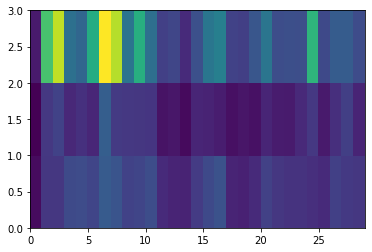

In [30]:
plt.pcolormesh(norm_rmse_folds)

In [60]:
norm_rmse_folds.shape

(3, 29)

Average the metrics across folds to get a summary value for all predictions.

<BarContainer object of 29 artists>

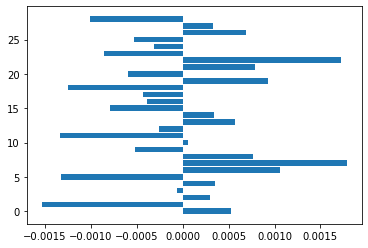

In [64]:
plt.barh(np.arange(29), norm_me_folds.mean(axis=0))

In [38]:
output_exp_cols

['Precursor [ug/m3]',
 'Gas [ug/m3] Bin01: lg(C*) = -5.5',
 'Gas [ug/m3] Bin02: lg(C*) = -4.5',
 'Gas [ug/m3] Bin03: lg(C*) = -3.5',
 'Gas [ug/m3] Bin04: lg(C*) = -2.5',
 'Gas [ug/m3] Bin05: lg(C*) = -1.5',
 'Gas [ug/m3] Bin06: lg(C*) = -0.5',
 'Gas [ug/m3] Bin07: lg(C*) =  0.5',
 'Gas [ug/m3] Bin08: lg(C*) =  1.5',
 'Gas [ug/m3] Bin09: lg(C*) =  2.5',
 'Gas [ug/m3] Bin10: lg(C*) =  3.5',
 'Gas [ug/m3] Bin11: lg(C*) =  4.5',
 'Gas [ug/m3] Bin12: lg(C*) =  5.5',
 'Gas [ug/m3] Bin13: lg(C*) =  6.5',
 'Gas [ug/m3] Bin14: lg(C*) = -6.5',
 'Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
 'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
 'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
 'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
 'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
 'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
 'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
 'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
 'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
 'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
 'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
 'Aerosol

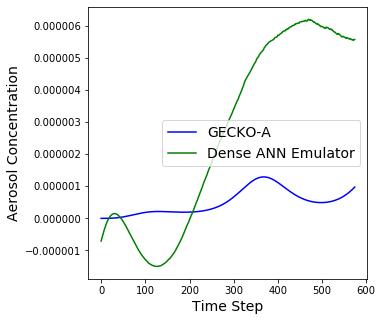

In [29]:
col = output_data.columns[output_data.columns.str.contains("Aerosol")][11]
plt.figure(figsize=(5, 5))
plt.plot(output_data.loc[:574, col], color='blue', label="GECKO-A")

plt.plot(out_preds_df.loc[:574, col], color="green", label="Dense ANN Emulator")
plt.ylabel("Aerosol Concentration", fontsize=14)
plt.xlabel("Time Step", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("nn_example.png", dpi=200, bbox_inches="tight")

In [68]:
output_data.columns[output_data.columns.str.contains("Aerosol")]

Index(['Aerosol [ug_m3] Bin01: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin07: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  1.5',
       'Aerosol [ug_m3] Bin09: lg(C*) =  2.5',
       'Aerosol [ug_m3] Bin10: lg(C*) =  3.5',
       'Aerosol [ug_m3] Bin11: lg(C*) =  4.5',
       'Aerosol [ug_m3] Bin12: lg(C*) =  5.5',
       'Aerosol [ug_m3] Bin13: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin14: lg(C*) = -6.5'],
      dtype='object')

In [59]:
(output_data.loc[:575, output_data.columns.str.contains("Gas")] - out_preds.loc[:575, output_data.columns.str.contains("Gas")]).values.max()

6.023957810852298e-06

In [16]:
for col in exp_data_merged.columns:
    print(repr(col))

'Time [s]'
'Precursor [ug/m3]'
'Gas [ug/m3] Bin01: lg(C*) = -5.5'
'Gas [ug/m3] Bin02: lg(C*) = -4.5'
'Gas [ug/m3] Bin03: lg(C*) = -3.5'
'Gas [ug/m3] Bin04: lg(C*) = -2.5'
'Gas [ug/m3] Bin05: lg(C*) = -1.5'
'Gas [ug/m3] Bin06: lg(C*) = -0.5'
'Gas [ug/m3] Bin07: lg(C*) =  0.5'
'Gas [ug/m3] Bin08: lg(C*) =  1.5'
'Gas [ug/m3] Bin09: lg(C*) =  2.5'
'Gas [ug/m3] Bin10: lg(C*) =  3.5'
'Gas [ug/m3] Bin11: lg(C*) =  4.5'
'Gas [ug/m3] Bin12: lg(C*) =  5.5'
'Gas [ug/m3] Bin13: lg(C*) =  6.5'
'Gas [ug/m3] Bin14: lg(C*) = -6.5'
'Aerosol [ug_m3] Bin01: lg(C*) = -5.5'
'Aerosol [ug_m3] Bin02: lg(C*) = -4.5'
'Aerosol [ug_m3] Bin03: lg(C*) = -3.5'
'Aerosol [ug_m3] Bin04: lg(C*) = -2.5'
'Aerosol [ug_m3] Bin05: lg(C*) = -1.5'
'Aerosol [ug_m3] Bin06: lg(C*) = -0.5'
'Aerosol [ug_m3] Bin07: lg(C*) =  0.5'
'Aerosol [ug_m3] Bin08: lg(C*) =  1.5'
'Aerosol [ug_m3] Bin09: lg(C*) =  2.5'
'Aerosol [ug_m3] Bin10: lg(C*) =  3.5'
'Aerosol [ug_m3] Bin11: lg(C*) =  4.5'
'Aerosol [ug_m3] Bin12: lg(C*) =  5.5'
'Aerosol [u

# Old exploratory processing code

In [9]:
data = pd.read_csv("/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene_kOH/Batch1_toluene/ML2019_toluene_kOH_ML2019_Exp0.csv")

In [13]:
exp_data_path = "/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/"
exp_data_files = sorted(glob(join(exp_data_path, "ML2019*.csv")))

In [72]:
file_template = "ML2019_toluene_ML2019_{exp}.csv"
exp_data = []
for exp in master_list["id"]:
    filename = join(exp_data_path, f"ML2019_toluene_ML2019_{exp}.csv")
    exp_data.append(pd.read_csv(filename))
    exp_data[-1].insert(0, "id", exp)

In [74]:
all_exp_data = pd.concat(exp_data, ignore_index=True)

In [76]:
all_exp_data.merge(master_list, on="id")

,id,Gas Phase [ug m-3],Aerosol Phase [ug m-3],Precursor [ug m-3],Pvap bin lower limit [log10(Cstar)],Pvap bin upper limit [log10(Cstar)],Time [s],Kh [M/atm],MW [g/mol],Yield (SOA),...,Atomic O/C ratio,Atomic H/C ratio,Atomic N/C ratio,Vaporization Enthalpy [J/mol],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
0,Exp0,0.000000,0.000000e+00,0.000000,-16.0,-6.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
1,Exp0,0.000000,0.000000e+00,0.000000,-6.0,-5.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
2,Exp0,0.000000,0.000000e+00,0.000000,-5.0,-4.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
3,Exp0,0.000000,0.000000e+00,0.000000,-4.0,-3.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
4,Exp0,0.000000,0.000000e+00,0.000000,-3.0,-2.0,1.0,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,300,0,10.00,10,0.01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13547515,Exp1679,0.000037,5.037846e-09,0.000000,2.0,3.0,172800.0,5.974230e+11,190.878196,0.0,...,1.398678,1.001275,0.198914,111930.948306,300,90,0.01,90,10.00,10
13547516,Exp1679,0.007719,1.846604e-07,0.000000,3.0,4.0,172800.0,2.099617e+10,190.256154,0.0,...,0.776976,0.757387,0.310681,98830.435047,300,90,0.01,90,10.00,10
13547517,Exp1679,0.000253,1.129703e-09,0.000000,4.0,5.0,172800.0,1.920989e+10,170.001702,0.0,...,1.410147,0.882486,0.267623,94664.634832,300,90,0.01,90,10.00,10
13547518,Exp1679,0.000652,1.658724e-10,0.000000,5.0,6.0,172800.0,4.678444e+07,124.006908,0.0,...,0.768145,0.866488,0.038317,78111.230330,300,90,0.01,90,10.00,10


In [107]:
exp_0.columns.str.lstrip()

Index(['Gas Phase [ug m-3]', 'Aerosol Phase [ug m-3]', 'Precursor [ug m-3]',
       'Pvap bin lower limit [log10(Cstar)]',
       'Pvap bin upper limit [log10(Cstar)]', 'Time [s]', 'Kh [M/atm]',
       'MW [g/mol]', 'Yield (SOA)', 'Yield (total)', 'Atomic O/C ratio',
       'Atomic H/C ratio', 'Atomic N/C ratio',
       'Vaporization Enthalpy [J/mol]                                                                                                 '],
      dtype='object')

In [64]:
! du -sh /glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/

5.2G	/glade/scratch/siyuan/POSTPROCESSING/ML2019_toluene/ML2019_toluene_postproc/


In [91]:
exp_0 = pd.read_csv(exp_data_files[42])

In [92]:
times = np.sort(exp_0[" Time [s]"].unique())

In [93]:
bin_aerosol_vectors = exp_0[" Aerosol Phase [ug m-3]"].values.reshape(times.size, 14)

In [94]:
bin_gas_vectors = exp_0[" Gas Phase [ug m-3]"].values.reshape(times.size, 14)

In [95]:
bin_values = exp_0[' Pvap bin lower limit [log10(Cstar)]'][exp_0[" Time [s]"] == times[0]].values
bin_values = np.append(bin_values, [16])

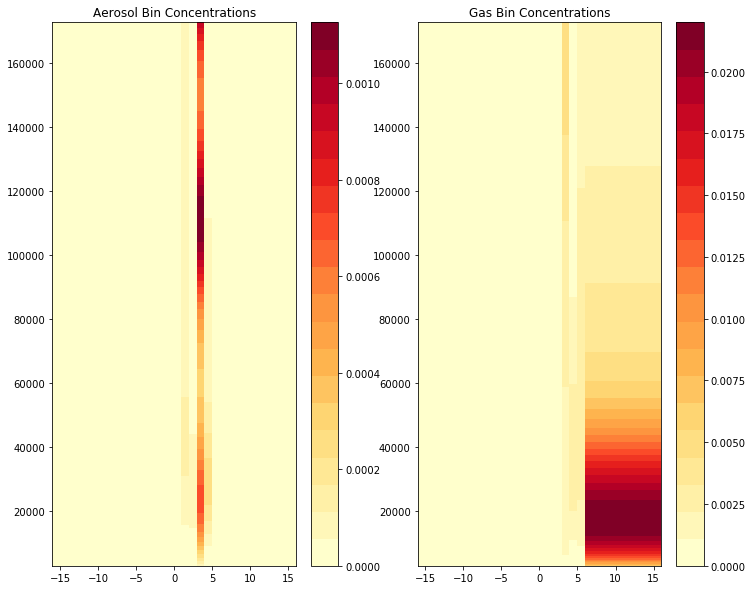

In [104]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(bin_values, times[10:], bin_aerosol_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20))
plt.title("Aerosol Bin Concentrations")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(bin_values, times[10:], bin_gas_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20))
plt.title("Gas Bin Concentrations")
plt.colorbar()


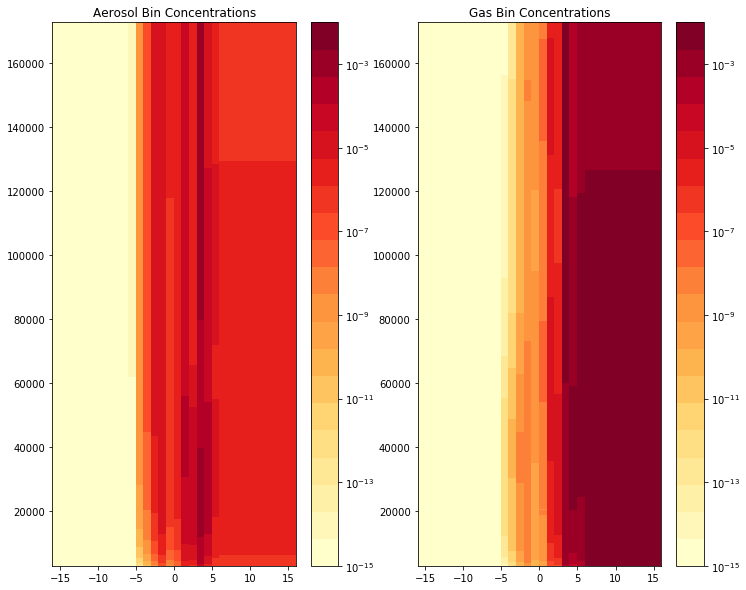

In [103]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(bin_values, times[10:], bin_aerosol_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20), norm=LogNorm(1e-15, 0.01))
plt.title("Aerosol Bin Concentrations")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(bin_values, times[10:], bin_gas_vectors[10:], cmap=plt.get_cmap("YlOrRd", 20), norm=LogNorm(1e-15, 0.01))
plt.title("Gas Bin Concentrations")
plt.colorbar()


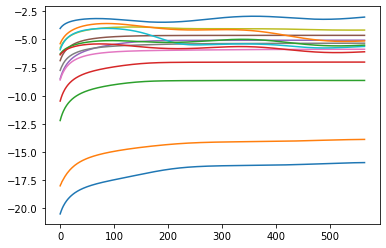

In [105]:
plt.plot(np.log10(bin_aerosol_vectors[10:, :]))

In [82]:
bin_aerosol_vectors.shape

(576, 14)

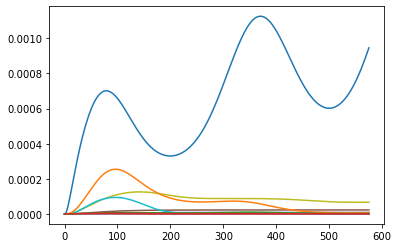

In [98]:
plt.plot(bin_aerosol_vectors)

## February 7, 2020
* Action items
* Train on predicting the total (aersol + gas) mass in each bin
* Evaluate the total mass across bins predicted by 